In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import PowerIterationClustering

In [2]:
# A helper function to compute pairwise (Euclidean) distances between data points
def Distance_Computing(entry, DF, p=2):
    # Obtain the coordinate of the point
    point = entry[1]
    # Compute the pairwise distances between this point and other points in the data
    dist = np.empty([DF.shape[0], ], dtype='float64')
    for i in range(DF.shape[0]):
        dist[i] = np.linalg.norm(point - DF[i,:], ord=p)
    return (entry[0], dist)

In [3]:
# A helper function: Transform the pairwise distances to the required similarity entry of pyspark PIC
def Affinity(entry, sigma=1):
    ID = entry[0]
    dists = entry[1]
    tuple_lst = []
    for i in range(ID, len(dists)):
        tuple_lst.append((ID, i, np.exp(-dists[i]/(2*sigma))))
    return tuple_lst

In [4]:
def Power_Iteration_Clustering(X, K, Adj=False, Lp_norm=2, sigma=1, max_Iter=20):
    '''
    Input: 
        X : [n_samples, n_samples] numpy array if adj=True, or, a [n_samples_a, n_features] array otherwise;
        K: int, The number of clusters;
        adj: boolean, Indicating whether the adjacency matrix is pre-computed. Default: False;
        Lp_norm: int, Indicating which L^p norm is using. Default: 2;
        sigma: float, The variance for the Gaussian (aka RBF) kernel. Default: 1;
        max_Iter: int, Maximum number of iterations of the PIC algorithm. Default: 20.
    Output:
        cluster labels: A [n_samples, ] numpy array,
        node ids: A list with length "n_samples".
    '''
    # Setting up PySpark Context
    conf = SparkConf()
    sc = SparkContext(conf=conf)
    
    if Adj:
        # Concatenate the point ID to the last column of the array
        X1 = np.concatenate((X, np.array(range(X.shape[0]), ndmin=2).T), axis=1)
        data = sc.parallelize(X1.tolist())
        # Manipulate the RDD such that each entry is a tuple of the form (ID, distance_list)
        Adj_matRDD = data.map(lambda x: (int(x[len(x)-1]), x[:(len(x)-1)]))
    else:
        X1 = np.concatenate((X, np.array(range(X.shape[0]), ndmin=2).T), axis=1)
        data = sc.parallelize(X1.tolist())
        data = data.map(lambda x: (int(x[len(x)-1]), x[:(len(x)-1)]))
        # Compute the pairwise distances between points
        Adj_matRDD = data.map(lambda item: Distance_Computing(item, DF=X, p=Lp_norm))
    
    # Transform the affinity matrix such that each element in the list has the form (i, j, s_{ij})
    A_RDD = Adj_matRDD.flatMap(lambda item: Affinity(item, sigma=sigma))
    # Cluster the data into two classes using PowerIterationClustering
    model = PowerIterationClustering.train(A_RDD, K, 100)
    
    cluster_id = model.assignments().collect()
    sc.stop()
    IDs = [k.id for k in cluster_id]
    clusters = [k.cluster for k in cluster_id]
    # Sort the cluster label list based on the ascending order of their IDs
    IDs_sorted = sorted(IDs)
    clusters_sorted = np.array(clusters)[np.argsort(IDs)]
    
    return clusters_sorted, IDs_sorted

In [5]:
def main():
    # Generate a toy dataset
    N = 500
    mean1 = [3, 0]
    cov1 = [[0.3, 0], [0, 0.8]]  # diagonal covariance
    mean2 = [-1, 4]
    cov2 = [[0.2, 0], [0, 1]]  # diagonal covariance
    a = np.random.multivariate_normal(mean1, cov1, N)
    b = np.random.multivariate_normal(mean2, cov2, N)
    big_data = np.concatenate((a, b), axis=0)
    labels = np.concatenate((np.repeat(0, N), np.repeat(1, N)))
    
    plt.figure()
    plt.scatter(x=big_data[:, 0], y=big_data[:, 1], c=labels, s=2)
    plt.colorbar()
    
    PIC_labels, IDs = Power_Iteration_Clustering(big_data, K=2, Lp_norm=2, sigma=1, max_Iter=20)
    
    plt.figure()
    plt.scatter(x=big_data[:, 0], y=big_data[:, 1], c=PIC_labels, s=2)
    plt.colorbar()
    plt.show()

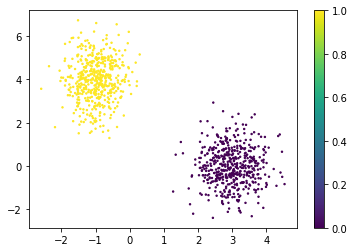

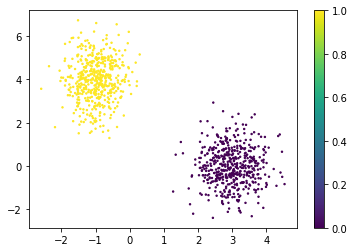

In [6]:
main()